<a href="https://colab.research.google.com/github/bmurmann/Ngspice-on-Colab/blob/main/notebooks/GF180MCU_VGS_sweep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GF180MCU V<sub>GS</sub> sweep

# Tool setup

In [1]:
# install conda
import os
CONDA_PREFIX = os.environ.get('CONDA_PREFIX', None)
if not CONDA_PREFIX:
  !python -m pip install condacolab
  import condacolab
  condacolab.install()

# install gf180mcuc
!conda install -c litex-hub open_pdks.gf180mcuc

# install ngspice
!conda install -c litex-hub ngspice

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:12
🔁 Restarting kernel...
Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done


==> WARNING: A newer version of conda exists. <==
  current version: 23.1.0
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.11.0



## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - open_pdks.gf180mcuc


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.11.17 |       hbcca054_0         151 KB  conda-forge
    certifi-2

# Simulation

In [2]:
%%writefile .spiceinit
set ngbehavior=hs

Writing .spiceinit


In [1]:
%%writefile netlist.spice
* PMOS VGS sweep

.include "/usr/local/share/pdk/gf180mcuC/libs.tech/ngspice/design.ngspice"
.lib "/usr/local/share/pdk/gf180mcuC/libs.tech/ngspice/sm141064.ngspice" typical

.param width=10u
X1 vdp vgp 0 vbp pfet_03v3 w=width l=0.28u AD={width*0.24u} AS={width*0.24u} PD={2*(width + 0.24u)} PS={2*(width + 0.24u)}
vsdp     0  vdp        dc 0.9
vsgp     0  vgp        dc 0.9
vsbp     0  vbp        dc 0
.op
.option post nomod
.end

.control
save all @m.x1.m0[id] @m.x1.m0[gm]  @m.x1.m0[cgg]
dc vsgp 0 1.8 0.01
display
wrdata output.txt @m.x1.m0[gm] @m.x1.m0[id]  @m.x1.m0[cgg]
.endc

Writing netlist.spice


In [3]:
!ngspice -b netlist.spice


Note: Compatibility modes selected: hs



Circuit: * pmos vgs sweep

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


No. of Data Rows : 181
Here are the vectors currently active:

Title: * pmos vgs sweep
Name: dc1 (DC transfer characteristic)
Date: Fri Dec  8 17:41:12  2023

    @m.x1.m0[cgg]       : capacitance, real, 181 long
    @m.x1.m0[gm]        : admittance, real, 181 long
    @m.x1.m0[id]        : current, real, 181 long
    v-sweep             : voltage, real, 181 long [default scale]
    vbp                 : voltage, real, 181 long
    vdp                 : voltage, real, 181 long
    vgp                 : voltage, real, 181 long
    vsbp#branch         : current, real, 181 long
    vsdp#branch         : current, real, 181 long
    vsgp#branch         : current, real, 181 long
Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


No. of Data Rows : 1
	Node                                  Voltage
	----                                  -------
	----	-------
	vb

In [4]:
import math
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("output.txt", delim_whitespace=True, header=None)
df.columns = ["vsg", "gm", "vsg1", "id", "vsg2", "cgg"]
df['gm_id'] = df['gm']/df['id']
df['f_T'] = df['gm']/df['cgg']/2/math.pi
df

,vsg,gm,vsg1,id,vsg2,cgg,gm_id,f_T
0,0.00,6.266460e-13,0.00,2.327947e-14,0.00,5.090079e-15,26.918395,1.959376e+01
1,0.01,8.202064e-13,0.01,3.047037e-14,0.01,5.067127e-15,26.918166,2.576211e+01
2,0.02,1.073550e-12,0.02,3.988240e-14,0.02,5.044596e-15,26.917903,3.387008e+01
3,0.03,1.405141e-12,0.03,5.220157e-14,0.03,5.022486e-15,26.917602,4.452678e+01
4,0.04,1.839142e-12,0.04,6.832576e-14,0.04,5.000804e-15,26.917256,5.853230e+01
...,...,...,...,...,...,...,...,...
176,1.76,8.077414e-04,1.76,5.645906e-04,1.76,9.709857e-15,1.430668,1.323975e+10
177,1.77,8.080913e-04,1.77,5.726699e-04,1.77,9.714894e-15,1.411094,1.323861e+10
178,1.78,8.082642e-04,1.78,5.807518e-04,1.78,9.720098e-15,1.391755,1.323436e+10
179,1.79,8.082598e-04,1.79,5.888346e-04,1.79,9.725480e-15,1.372643,1.322696e+10


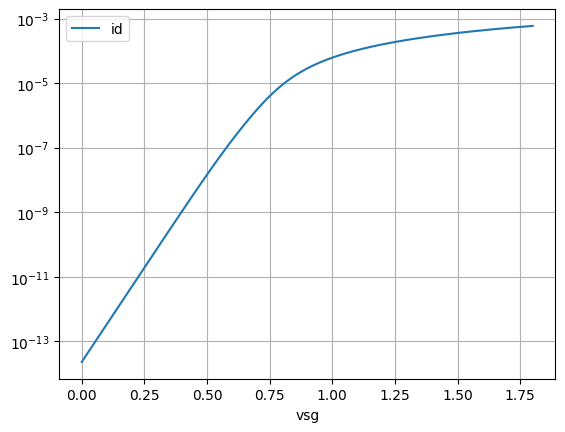

In [5]:
df.plot(x="vsg", y="id", logy=True, grid=True)
plt.show()

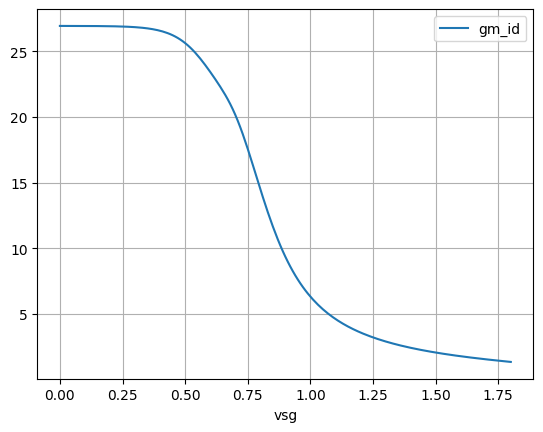

In [6]:
df.plot(x="vsg", y="gm_id", grid=True)
plt.show()

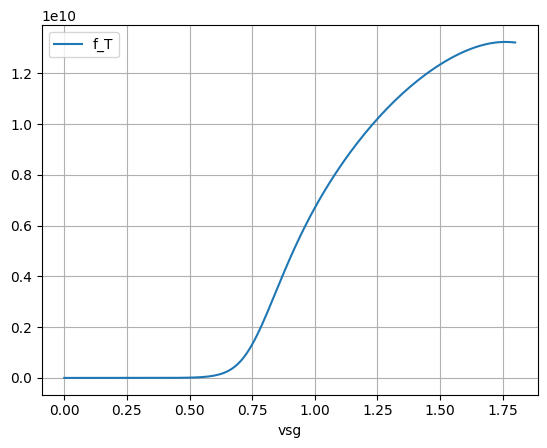

In [7]:
df.plot(x="vsg", y="f_T", grid=True)
plt.show()